# ANN_SPX

Table of Contents
- [1. Preprocessing Data](#1-preprocessing-the-data)
- [2. Model for Calls ONLY](#2-model-for-calls-only)
  - [2.1 Stage 1 Model (Binary Classifier)](#21-stage-1-model-binary-classifier)
  - [2.2 Stage 2 Model (Price Prediction)](#22-stage-2-model-price-prediction)
  - [2.3 Testing model](#23-testing-model)
- [3. Model for Puts ONLY](#3-model-for-puts-only)
  - [3.1 Stage 1 Model (Binary Classifier)](#31-stage-1-model-binary-classifier)
  - [3.2 Stage 2 Model (Price Prediction)](#32-stage-2-model-price-prediction)
  - [3.3 Testing model](#33-testing-model)
- [4. Hyperparam Tuning](#4-hyperparam-tuning)
  - [4.1 Model for Calls ONLY](#41-model-for-calls-only)
    - [4.1.1 Hyperparam Tuning (Binary Classifier)](#411-hyperparam-tuning-binary-classifier)
    - [4.1.2 Hyperparam Tuning (Price Prediction)](#412-hyperparam-tuning-price-prediction)
  - [4.2 Model for Puts ONLY](#42-model-for-calls-only)
    - [4.2.1 Hyperparam Tuning (Binary Classifier)](#421-hyperparam-tuning-binary-classifier)
    - [4.2.2 Hyperparam Tuning (Price Prediction)](#422-hyperparam-tuning-price-prediction)

<u>Stage 1: Binary Classification Model</u>

The first model is responsible for predicting if the option is “purchasable.” It classifies the input based on whether to proceed with price prediction or not.

- Input Layer
    - 14 neurons (one for each input feature).
- Hidden Layer
    - 1 Layer, 28 neurons (Leaky RelU)
- Output Layer
    - 1 neuron with a sigmoid activation function to produce a binary result:
        - Output = 1 if the option is “purchasable” (indicating "Buy the option").
        - Output = 0 if the option is “not purchasable” (indicating "Do not buy").

<u>Stage 2: Price Prediction Model</u>

Only if the classification model predicts the option as “purchasable” (1) does the data proceed to this model. This model predicts the price of the option.

- Input Layer
    - 15 neurons (same input features as the classification model).
- Hidden Layers (Price Prediction Layer)
    - First layer, 30 neurons (Leaky ReLU)
    - Second Layer, 15 neurons (Leaky ReLU)
- Output Layer
    - 1 neuron without activation (for regression) to predict the option price.

> **Note:** The hyperparameter tuning at the end of this file can take **more than 30 minutes** to run as it uses **RandomizedSearchCV**.  
> If you are short on time, avoid running **Section 4** of this code.


# 1. Preprocessing the Data

In [88]:
import pandas as pd
import numpy as np

In [89]:
df1 = pd.read_csv('df1_modified.csv')
df3 = pd.read_csv('df2_modified.csv')
df2 = pd.read_csv('df3_modified.csv')
df4 = pd.read_csv('df4_modified.csv')
df5 = pd.read_csv('df5_modified.csv')
df6 = pd.read_csv('df6_modified.csv')

In [90]:
df_train = pd.concat([
    df1[(df1['root']=='SPX')],
    df2[(df2['root']=='SPX')],
    df3[(df3['root']=='SPX')],
    df4[(df4['root']=='SPX')],
    df5[(df5['root']=='SPX')]
])
df_test = df6[df6['root'] == 'SPX'].copy()

In [91]:
# Transforming relevant columns to datetime
df_train['expiration'] = pd.to_datetime(df_train['expiration'])
df_train['quote_datetime'] = pd.to_datetime(df_train['quote_datetime'])

df_test['expiration'] = pd.to_datetime(df_test['expiration'])
df_test['quote_datetime'] = pd.to_datetime(df_test['quote_datetime'])

# Calculate time-to-expiration as the difference in days
df_train['time_to_expiration'] = (df_train['expiration'] - df_train['quote_datetime']).dt.days
df_test['time_to_expiration'] = (df_test['expiration'] - df_test['quote_datetime']).dt.days

In [92]:
# New column bid_ask_spread
df_train['bid_ask_spread'] = df_train['underlying_ask'] - df_train['underlying_bid']
df_test['bid_ask_spread'] = df_test['underlying_ask'] - df_test['underlying_bid']

In [93]:
# New column is_buy, shows whether an option was bought
df_train['is_buy'] = ((df_train['trade_volume'] > 0) & (df_train['close'] != 0)).astype(int)
df_test['is_buy'] = ((df_test['trade_volume'] > 0) & (df_test['close'] != 0)).astype(int)

In [94]:
df_train_calls = df_train[df_train['option_type']=='C']
df_test_calls = df_test[df_test['option_type']=='C']

df_train_puts = df_train[df_train['option_type']=='P']
df_test_puts = df_test[df_test['option_type']=='P']

In [95]:
# Dropping irrelevant columns
# root, underlying_symbol, option_type, implied_underlying_price, quote_datetime, expiration, bid_size, ask_size, underlying_bid, underlying_ask, open, high, low
columns_to_drop = ['root', 'option_type','underlying_symbol', 'implied_underlying_price', 'quote_datetime', 
                   'expiration', 'open', 'high', 'low', 'bid_size', 'ask_size', 'time_to_maturity',
                   'underlying_bid', 'underlying_ask', 'bid','ask']

df_train_calls = df_train_calls.drop(columns = columns_to_drop, axis=1)
df_train_puts = df_train_puts.drop(columns = columns_to_drop, axis=1)
df_test_calls = df_test_calls.drop(columns = columns_to_drop, axis=1)
df_test_puts = df_test_puts.drop(columns = columns_to_drop, axis=1)

# 2. Model for Calls ONLY

In [96]:
# Scaling features
from sklearn.preprocessing import StandardScaler

numerical_columns = ['strike', 'close', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'risk_free_rate', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_calls[numerical_columns] = scaler.fit_transform(df_train_calls[numerical_columns])
df_test_calls[numerical_columns] = scaler.transform(df_test_calls[numerical_columns])

## 2.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 4.1.2](#241-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 14
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 16

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the binary classifier model
binary_classifier_calls = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_calls.add(Input(shape=(14,)))

# Hidden layer with 14 neurons
binary_classifier_calls.add(Dense(units=14))
binary_classifier_calls.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_calls.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_calls.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_calls.summary()


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_330 (Dense)               │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_198 (LeakyReLU)     │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Separate features and target for training
X_train = df_train_calls.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification

In [99]:
# Training the binary classifier
history = binary_classifier_calls.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)


Epoch 1/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step - accuracy: 0.9393 - loss: 0.1584 - val_accuracy: 0.9965 - val_loss: 0.0146
Epoch 2/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 243us/step - accuracy: 0.9947 - loss: 0.0162 - val_accuracy: 0.9971 - val_loss: 0.0083
Epoch 3/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.9979 - val_loss: 0.0058
Epoch 4/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step - accuracy: 0.9977 - loss: 0.0074 - val_accuracy: 0.9990 - val_loss: 0.0048
Epoch 5/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 6/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 7/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9993 - val_loss: 0.0028
Epoch 8/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 237us/step - accuracy: 0.9989 -

In [100]:
import matplotlib.pyplot as plt

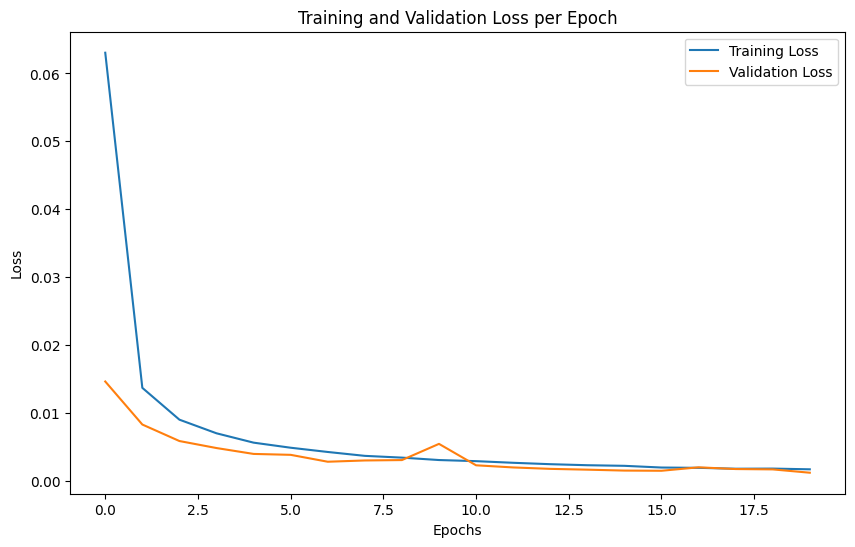

In [101]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [102]:
# Separate features and target for the price prediction model
X_train_calls = df_train_calls.drop(columns=['is_buy','option_price'])  # Features for price prediction
y_train_price_full = df_train_calls['option_price']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_calls.predict(X_train_calls) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_calls[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

4312/4312 ━━━━━━━━━━━━━━━━━━━━ 1s 165us/step


## 2.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 4.1.2](#412-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 56
- Hidden Layer 2 No. of Neurons: 7
- Model Learning Rate: 0.01
- Epochs: 10
- Batch Size: 16

In [103]:
# Define the price prediction model
price_prediction_model_calls = Sequential()

# Input layer with 14 neurons
price_prediction_model_calls.add(Input(shape=(14,))) 

# First hidden layer with 56 neurons
price_prediction_model_calls.add(Dense(units=56))  
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 7 neurons and Leaky ReLU activation
price_prediction_model_calls.add(Dense(units=7))
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_calls.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_calls.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Summary of the model architecture
price_prediction_model_calls.summary()


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_332 (Dense)               │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_199 (LeakyReLU)     │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 7)              │           399 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_200 (LeakyReLU)     │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,247 (4.87 KB)

 Trainable params: 1,247 (4.87 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
# Train the price prediction model
history = price_prediction_model_calls.fit(X_train_price, y_train_price, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 113323.9609 - val_loss: 13854.5732
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 7245.7021 - val_loss: 1181.9685
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 2957.7493 - val_loss: 5715.2944
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 4443.5469 - val_loss: 2196.2595
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 2147.1143 - val_loss: 17252.9844
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 4557.2031 - val_loss: 8544.8418
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 3322.9644 - val_loss: 1281.2361
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 1883.0892 - val_loss: 1061.1062
Epoch 9/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 4222.4600 - val_loss: 2423.6995
Epoch 10/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 1902.8320 - val_loss: 1539.4058


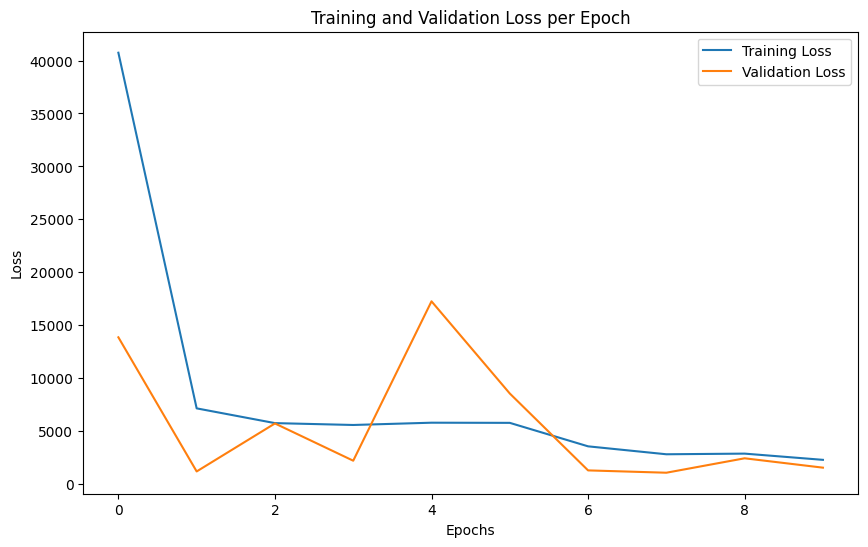

In [105]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 2.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [107]:
# Features and target for binary classification model
X_test_classification = df_test_calls.drop(columns=['option_price', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_calls['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_calls.drop(columns=['is_buy', 'option_price'])  # Features for price prediction
y_test_price_full = df_test_calls['option_price']                      # Target price for price prediction

In [108]:
y_pred_binary = (binary_classifier_calls.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


872/872 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step
Binary Classifier Metrics:
Accuracy: 0.999964160275249
Precision: 1.0
Recall: 0.9993279569892473
F1-Score: 0.9996638655462184


In [109]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [110]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_calls.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step

Price Prediction Model Metrics:
Mean Squared Error: 1858.5508389702677
Root Mean Squared Error: 43.11091322357099
Mean Absolute Error: 20.85099412590045
R-squared: 0.9942611676558529


# 3. Model for Puts ONLY

In [111]:
# Scaling
numerical_columns = ['strike', 'close', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'risk_free_rate', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_puts[numerical_columns] = scaler.fit_transform(df_train_puts[numerical_columns])
df_test_puts[numerical_columns] = scaler.transform(df_test_puts[numerical_columns])

## 3.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 4.2.1](#421-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 14
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 16

In [112]:
# Define the binary classifier model
binary_classifier_puts = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_puts.add(Input(shape=(14,)))

# Hidden layer with 14 neurons
binary_classifier_puts.add(Dense(units=14))
binary_classifier_puts.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_puts.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_puts.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_puts.summary()


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_335 (Dense)               │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_201 (LeakyReLU)     │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [113]:
# Separate features and target for training
X_train = df_train_puts.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification

In [114]:
# Training the binary classifier
history = binary_classifier_puts.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 3s 272us/step - accuracy: 0.9416 - loss: 0.1617 - val_accuracy: 0.9926 - val_loss: 0.0262
Epoch 2/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step - accuracy: 0.9913 - loss: 0.0253 - val_accuracy: 0.9965 - val_loss: 0.0151
Epoch 3/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step - accuracy: 0.9950 - loss: 0.0154 - val_accuracy: 0.9971 - val_loss: 0.0113
Epoch 4/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step - accuracy: 0.9960 - loss: 0.0122 - val_accuracy: 0.9966 - val_loss: 0.0084
Epoch 5/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.9988 - val_loss: 0.0070
Epoch 6/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step - accuracy: 0.9978 - loss: 0.0077 - val_accuracy: 0.9984 - val_loss: 0.0054
Epoch 7/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9985 - val_loss: 0.0042
Epoch 8/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step - accuracy: 0.9983 -

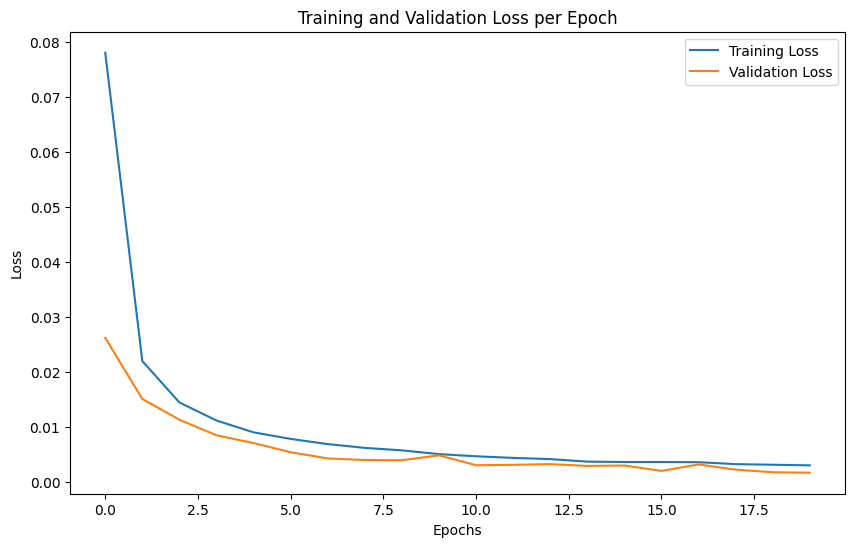

In [115]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [116]:
# Separate features and target for the price prediction model
X_train_puts = df_train_puts.drop(columns=['is_buy','option_price'])  # Features for price prediction
y_train_price_full = df_train_puts['option_price']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_puts.predict(X_train_puts) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_puts[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

4312/4312 ━━━━━━━━━━━━━━━━━━━━ 1s 179us/step


## 3.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 4.2.2](#422-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 56
- Hidden Layer 2 No. of Neurons: 28
- Model Learning Rate: 0.001
- Epochs: 30
- Batch Size: 32

In [117]:
# Define the price prediction model
price_prediction_model_puts = Sequential()

# Input layer with 14 neurons and first hidden layer with 14 neurons
price_prediction_model_puts.add(Input(shape=(14,)))
price_prediction_model_puts.add(Dense(units=14))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 28 neurons and Leaky ReLU activation
price_prediction_model_puts.add(Dense(units=28))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_puts.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_puts.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model architecture
price_prediction_model_puts.summary()


Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_337 (Dense)               │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_202 (LeakyReLU)     │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 28)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_203 (LeakyReLU)     │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659 (2.57 KB)

 Trainable params: 659 (2.57 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
# Train the price prediction model
history = price_prediction_model_puts.fit(X_train_price, y_train_price, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 39386.4062 - val_loss: 25974.2305
Epoch 2/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 10140.5596 - val_loss: 6566.9058
Epoch 3/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 3919.2280 - val_loss: 2645.1743
Epoch 4/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 1055.1469 - val_loss: 905.0422
Epoch 5/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 607.2286 - val_loss: 373.0000
Epoch 6/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - loss: 260.4097 - val_loss: 258.4167
Epoch 7/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 190.2814 - val_loss: 215.4110
Epoch 8/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 144.0601 - val_loss: 155.3487
Epoch 9/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - loss: 99.0148 - val_loss: 119.3517
Epoch 10/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - loss: 72.4408 - val_loss: 97.8372
Epoch 11/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 63.9604 -

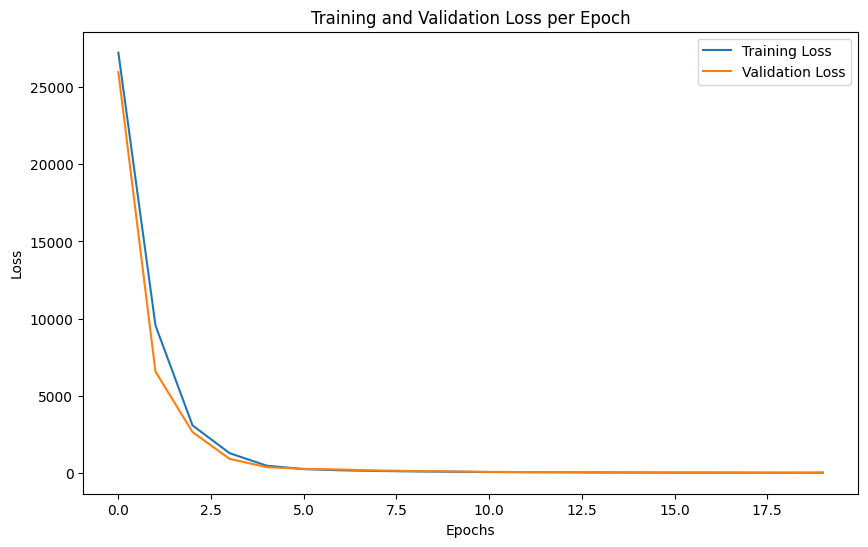

In [119]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 3.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [120]:
# Features and target for binary classification model
X_test_classification = df_test_puts.drop(columns=['option_price', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_puts['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_puts.drop(columns=['is_buy', 'option_price'])  # Features for price prediction
y_test_price_full = df_test_puts['option_price']                      # Target price for price prediction

In [121]:
y_pred_binary = (binary_classifier_puts.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


872/872 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
Binary Classifier Metrics:
Accuracy: 0.9998208013762454
Precision: 1.0
Recall: 0.99812734082397
F1-Score: 0.9990627928772259


In [122]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [123]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_puts.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step

Price Prediction Model Metrics:
Mean Squared Error: 19.151816719215663
Root Mean Squared Error: 4.376278866710354
Mean Absolute Error: 2.978840110665414
R-squared: 0.9993481895413665


# 4. Hyperparam Tuning

In this section, hyperparameter tuning will be conducted using random search cv to randomly iterate through combinations of values in a parameter grid. This has previously been used by our group to arrive at the parameters we have input to our models above. 

> **Note:** The hyperparameter tuning in this section can take **more than 30 minutes** to run as it uses **RandomizedSearchCV**.  
> If you are short on time, avoid running **Section 4** of this code.

In [37]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV 
from scikeras.wrappers import KerasRegressor

## 4.1 Model for Calls ONLY

### 4.1.1 Hyperparam Tuning (Binary Classifier)

In [38]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [39]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [40]:
# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


Best Hyperparameters: {'model__units': 14, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 16}
Best Score: 0.9994491009213853


### 4.1.2 Hyperparam Tuning (Price Prediction)

In [41]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [42]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [43]:
param_grid = {
    'model__units1': [14, 28, 56],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20, 30]                           # Number of epochs
}

In [44]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['option_price', 'is_buy'])  # Features for training
y_train = df_train_calls['option_price']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


Best Hyperparameters: {'model__units2': 7, 'model__units1': 56, 'model__learning_rate': 0.01, 'epochs': 10, 'batch_size': 16}
Best Score (Negative MSE): -1699.5545533535305


## 4.2 Model for Puts ONLY

### 4.2.1 Hyperparam Tuning (Binary Classifier)

In [45]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [46]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [47]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


Best Hyperparameters: {'model__units': 14, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 16}
Best Score: 0.9987314790766278


### 4.2.2 Hyperparam Tuning (Price Prediction)

In [48]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [49]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [50]:
param_grid = {
    'model__units1': [14, 28, 56],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20, 30]                           # Number of epochs
}

In [51]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['option_price', 'is_buy'])  # Features for training
y_train = df_train_puts['option_price']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)


# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


Best Hyperparameters: {'model__units2': 28, 'model__units1': 56, 'model__learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}
Best Score (Negative MSE): -220.12114684616458
